In [ ]:
import numpy as np
import pystorm as pst
from pystorm import mnt
from functools import partial
from MHT.simulators import *
from MHT.utils import *
from MHT.features import *
from MHT.stats import *
from MHT.expectation import *
from MHT.sampling.BaseSampler import BaseSampler
from MHT.sampling.CoupledNetworkModelSampler import CoupledNetworkModelSampler, SimulatedAnnealingSamplerCoupledNetwork
from MHT.hypothesis_formatting.AlphaCoupledNetworkModel import AlphaCoupledNetworkModel
from scipy.stats import ttest_rel, bws_test, levene
from statsmodels.regression.linear_model import OLS, OLSResults

In [ ]:
from matplotlib import cm,colors
import matplotlib.pyplot as plt
from MHT.plot_utils import *
ns = np.random.randint(0,1000)

In [ ]:
model_kwargs = {
    "is_noise_log_scale":True,
    "use_analytical_filter":False,
}
def sim_wrapper(connectivity,theta,alpha,model_fn,model_kwargs, psd_freq_indices = [4,50], **kwargs):
    S = connectivity
    if len(theta.shape) == 1:
        theta = theta[None,...]
        if len(S.shape) == 3:
            S_ = S[None,...]
        else:
            S_ = S
    else:
        S_ = S
    if len(S_.shape) == 3:
        S_ = np.concatenate([S[None,...] for _ in range(theta.shape[0])],axis = 0)
    params = alpha(theta)
    outputs = []
    for i,p in enumerate(params):
        output = model_fn(connectivity=S_[i],**p,**model_kwargs, **kwargs)
        outputs.append(output[0][...,psd_freq_indices[0]:psd_freq_indices[1]][None,...])
    outputs = np.concatenate(outputs,axis = 0)
    if outputs.shape[0] == 1:
        return [outputs.squeeze(axis=0)]
    return outputs


In [ ]:
n_nodes = 4
model_fn = get_WC_conn_PSD

parameters_ranges_og = mnt.ensure_numpy([
                                        [2.0, 18.0], [2.0, 14.0],[11.0, 17.0], [0, 15],    #c_xx
                                        [2.0, 9.0], [10.0, 50.0],   #tau_x
                                        [1, 3.5], [1, 4.],     #b_x
                                        [0.5, 2.5], [1., 4.5],     #a_x
                                        [0.5, 1.0], [0.5, 1.0], [0.5, 1.0], [0.5, 1.0],     #k_x,r_x
                                        [-6,-3],[-6,-3],   #Noise x 
                ])
parameters_ranges_ = dcp(parameters_ranges_og)
param_ = np.array([
        16  , 12.  , 15.  ,  0.0,
        8.  ,  30  ,
        2.,  3. ,
        1.0 , 1.25  ,
        1.  ,  1.  ,  1.  ,  1.  ,
        -4.5, -4.5
])
parameters_ranges_[-2] = parameters_ranges_[-2]*int(param_[-2]!=0)
parameters_ranges_[-1] = parameters_ranges_[-1]*int(param_[-1]!=0) 
parameters_range_width = np.diff(parameters_ranges_,axis = -1).squeeze()
parameters_ranges_[:,0] = np.where(parameters_ranges_[:,0]<=param_,parameters_ranges_[:,0],param_-(0.05*parameters_range_width))
parameters_ranges_[:,1] = np.where(parameters_ranges_[:,1]>=param_,parameters_ranges_[:,1],param_+(0.05*parameters_range_width))
parameters_base_single = dcp(param_)
local_template = parameters_base_single
full_local_template = np.zeros((n_nodes,local_template.shape[0])) + local_template[None,...]
coupling_template = mnt.ensure_numpy([4, 15.])
model_kwargs = {
    "is_noise_log_scale":True,
    "use_analytical_filter":False,
}
local_bounds = np.zeros((n_nodes,parameters_ranges_.shape[0],2)) + parameters_ranges_[None,...]
coupling_bounds = np.array([[2,7],[3,25.0]])
coupling_param_names = ["a", "K"]
parameter_bounds= {
    "coupling_params":coupling_bounds,
    "local_params":local_bounds
}

parameters_base_single = dcp(param_)

parameter_names = parameter_names_WC
parameter_latex_mapping_ = parameter_latex_mapping
nbias_nodes = 4
bias_node_start = 0
biased_noisy = {
    "local_params":{
        "c_ie":{
        "ids":[i for i in range(bias_node_start,bias_node_start+nbias_nodes)],
        "loc":np.array([-0.4 for i in range(bias_node_start,bias_node_start+nbias_nodes)]),
        "std":np.array([0.2 for i in range(bias_node_start,bias_node_start+nbias_nodes)]),
        },
    },
}
non_biased_noisy = {
    "local_params":{
        "theta_e":{
        "ids":[[0]],
        "std":np.array([0.15]),
        },
    },
}
local_free_parameters = {
}
for modif in [non_biased_noisy,biased_noisy]:
    if "local_params" in modif:
        for param_name in modif["local_params"]:
            if param_name not in local_free_parameters:
                local_free_parameters[param_name]= []
            for group in modif["local_params"][param_name]["ids"]:
                local_free_parameters[param_name].append(group)
coupling_free_parameters = [
    coupling_param_names[index]
            for modif in [biased_noisy,non_biased_noisy] if  "coupling_params" in modif
    for index in modif["coupling_params"]["ids"] 
]
full_local_template_gen = dcp(full_local_template)
full_coupling_template_gen = dcp(coupling_template)
parameter_bounds_gen = dcp(parameter_bounds)
for param_name in biased_noisy["local_params"]:
    for g,group in enumerate(biased_noisy["local_params"][param_name]["ids"]):
        slicing = mnt.ensure_numpy(group)
        loc = biased_noisy["local_params"][param_name]["loc"][g]
        range_val =  np.diff(parameter_bounds["local_params"][slicing, param_ind[param_name]],axis=-1).squeeze()
        
        full_local_template_gen[slicing, param_ind[param_name]] = full_local_template_gen[slicing, param_ind[param_name]] + range_val*loc
for modif in [biased_noisy,non_biased_noisy]:
    if "local_params" in modif:
        for param_name in modif["local_params"]:
            for g,group in enumerate(modif["local_params"][param_name]["ids"]):
                slicing = mnt.ensure_numpy(group)
                std = modif["local_params"][param_name]["std"][g]
                range_val =  np.diff(parameter_bounds["local_params"][slicing, param_ind[param_name]],axis=-1).squeeze()
                parameter_bounds_gen["local_params"][slicing, param_ind[param_name],0] = full_local_template_gen[slicing, param_ind[param_name]] - (range_val/2)*std
                parameter_bounds_gen["local_params"][slicing, param_ind[param_name],1] = full_local_template_gen[slicing, param_ind[param_name]] + (range_val/2)*std
parameter_bounds_gen["local_params"] = clip_bounds_change(parameter_bounds_gen["local_params"],parameter_bounds["local_params"])
if "coupling_params" in biased_noisy:
    for p, param_index in enumerate(biased_noisy["coupling_params"]["ids"]):
        loc = biased_noisy["coupling_params"]["loc"][p]
        range_val =  np.diff(parameter_bounds["coupling_params"][param_index],axis=-1).squeeze()
        full_coupling_template_gen[param_index] = full_coupling_template_gen[param_index] + range_val*loc
        parameter_bounds_gen["coupling_params"][param_index][0] = full_coupling_template_gen[param_index]
for modif in [biased_noisy,non_biased_noisy]:
    if "coupling_params" in modif:
        for p, param_index in enumerate(biased_noisy["coupling_params"]["ids"]):
            loc = biased_noisy["coupling_params"]["loc"][p]
            std = biased_noisy["coupling_params"]["std"][p]
            range_val =  np.diff(parameter_bounds["coupling_params"][param_index],axis=-1).squeeze()
            parameter_bounds_gen["coupling_params"][param_index][0] = full_coupling_template_gen[param_index]  - (range_val/2)*std
            parameter_bounds_gen["coupling_params"][param_index][1] = full_coupling_template_gen[param_index]  + (range_val/2)*std



In [ ]:
def G_fn_coupled(M):
    M_ = remove_diag(zpd(M,M.sum(-1).max(-1)),return_numpy=True)
    return M_

freq_offset,freq_res,freq_cutoff = 2. , 0.5, 50

psd_freqs = [freq_offset,freq_cutoff,freq_res]
psd_freq_indices = [int(freq_offset/freq_res),int(freq_cutoff/freq_res)]
n_total_freqs = psd_freq_indices[1] - psd_freq_indices[0]
band_ranges_ = np.array([
                        #[ 4, 98],
                        [ 4,  8],
                        [ 8, 16],
                        [16, 26],
                        [26, 60],
                        [60, freq_cutoff*2-1]
            ])
band_ranges = band_ranges_-freq_offset*2
freqs_gamma = np.arange(freq_offset,freq_cutoff,freq_res)
full_freq_range = [freqs_gamma.min()-freq_offset,freqs_gamma.max()-freq_offset]
z_freq_range = [5-freq_offset,25-freq_offset-freq_res]

F_fn_coupl0 = partial(
    within_band_power_coupl,
    band_freq_range=[8-freq_offset, 13-freq_offset], 
    freq_res=freq_res, node_sel=0,
    full_band_range = [full_freq_range[0],full_freq_range[1]-freq_res,[-1,-2]],
)
T_fn = partial(
    sum_normpower_for_freqs_along_axis,
    band_range = z_freq_range,
    full_band_range = [full_freq_range[0],full_freq_range[1]-freq_res,[-1,-2]],
    freq_res=freq_res
)
freqs_Z = np.arange(z_freq_range[0],z_freq_range[1]+freq_res,freq_res)+freq_offset
G_fn = G_fn_coupled

In [ ]:
F_fns = [F_fn_coupl0]
S_F_fn = lambda x: norm_max(x[:,0,0].sum(-1))
r_model_type,r_model_kwargs = StatsModelPolynomialWrapper, {"degree":1}
synthetic_model = partial(
    sim_wrapper,
    model_fn=model_fn, 
    model_kwargs=model_kwargs,
    psd_freq_indices=psd_freq_indices
)
newseed = False

In [ ]:
use_preexisting_data, save_data = True, False
if use_preexisting_data:
    experiment_data = get_log_(
        "./synthetic_data/",
        "experiment2_synthetic_data",
        extension="pkl"
    )
    synthetic_data_summary_unaltered = experiment_data["synthetic_data_summary_unaltered"]
    synthetic_data_unaltered = synthetic_data_summary_unaltered["data"]
    synthetic_data_unaltered_params = synthetic_data_summary_unaltered["params"]
    thetas_og = synthetic_data_unaltered_params["theta"]

    synthetic_data_summary_altered = experiment_data["synthetic_data_summary_altered"]
    synthetic_data_altered = synthetic_data_summary_altered["data"]
    synthetic_data_altered_params = synthetic_data_summary_altered["params"]
    S = synthetic_data_altered["S_full"]
    S_F = synthetic_data_altered["S"]
    n_samples = S.shape[0]
    produce_new_data = False
    produce_new_conn_data = False#True
    conn_exists = True
else:
    n_samples = 20
    produce_new_data = True
    produce_new_conn_data = True#True

In [ ]:
if produce_new_conn_data or not conn_exists:
    tract_range,tract_offset = 50,10
    conn_exists = True
    connectivity_matrix_base = np.abs(np.random.beta(0.5,6,size = (1,2,n_nodes,n_nodes)))
    vals = np.random.beta(6,2,size = (1,1,n_nodes,n_nodes))
    cutoff = 0.5
    ranges_ = max(vals.mean()-0.15,cutoff),min(vals.mean()+0.15,1.0)
    if (vals<cutoff).sum() > 0:
        replacement = (np.random.beta(3,2,size = ((vals<cutoff).sum()))) * (ranges_[1] - ranges_[0])
        replacement = replacement-replacement.mean() + vals.mean()
        vals[vals<cutoff] = replacement
    vals = ((vals-cutoff) * (tract_range/(1-cutoff)) + tract_offset)
    connectivity_matrix_base[...,1,:,:] = vals
    connectivity_matrix_base = remove_diag((np.swapaxes(connectivity_matrix_base,-2,-1) + connectivity_matrix_base)/2,return_numpy=True)
    node_order = connectivity_matrix_base[0,0,...].sum(-1).argsort(-1)[::-1]
    connectivity_matrix_base = connectivity_matrix_base[...,node_order,:][...,:,node_order]
    connectivity_matrix_base = remove_diag((np.swapaxes(connectivity_matrix_base,-2,-1) + connectivity_matrix_base)/2,return_numpy=True)
    connectivity_matrix_base[:,0,...] = zpd(connectivity_matrix_base[:,0,...],connectivity_matrix_base[:,0,...].sum(-1).max(-1))
    connectivity_matrix = np.zeros((n_samples,*connectivity_matrix_base.shape[1:])) + (connectivity_matrix_base)
    connectivity_matrix[:,0,0,:] = np.linspace(0.,0.5,n_samples)[...,None]  * connectivity_matrix_base[:,0,0,:]
    connectivity_matrix[:,0,:,0] = np.linspace(0.,0.5,n_samples)[...,None]  * connectivity_matrix_base[:,0,0,:]
    connectivity_matrix = remove_diag((np.swapaxes(connectivity_matrix,-2,-1) + connectivity_matrix)/2,return_numpy=True)

    M = connectivity_matrix
    S = dcp(M)
    S[:,0] = G_fn(M[:,0])
    S_F = S_F_fn(S)
    order = S_F.argsort()
    M = M[order,...]
    S = S[order,...]
    S_F = S_F[order,...]

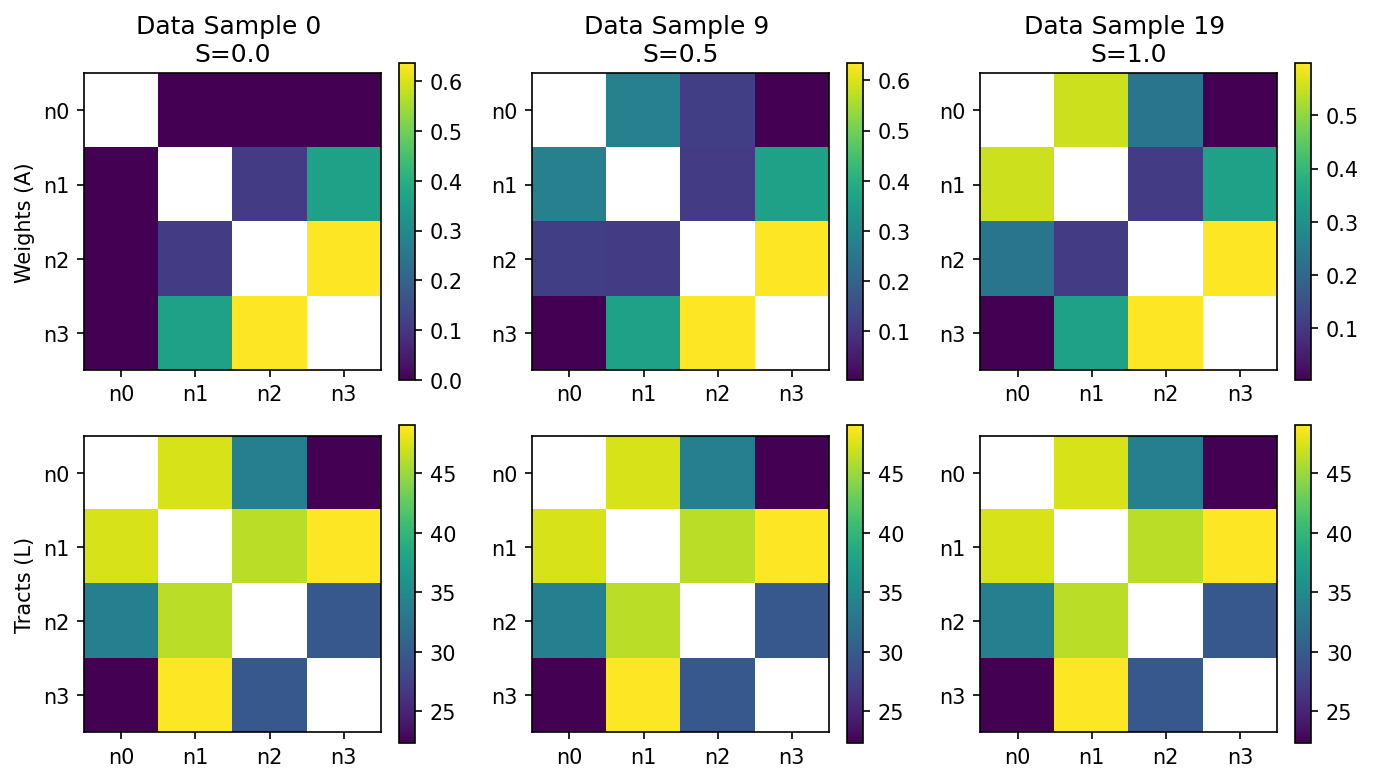

In [16]:
slicer_array = np.linspace(0,S.shape[0]-1,3,dtype=int)
plot_data = S[slicer_array,:,:,:]
plot_titles = [[f"Data Sample {s} \nS={round(S_F[s],2)}" for s in slicer_array],[f"" for s in slicer_array]]
ticks = [f"n{i}" for i in range(4)]
plot_AEC_grid(
    plot_data,titles=plot_titles,
    x_label="",y_label="",ylabel_header=['Weights (A)','Tracts (L)'],
    col_size=2.65,row_size=3.1*plot_data.shape[0],
    yticklabels=ticks,xticklabels=ticks
)

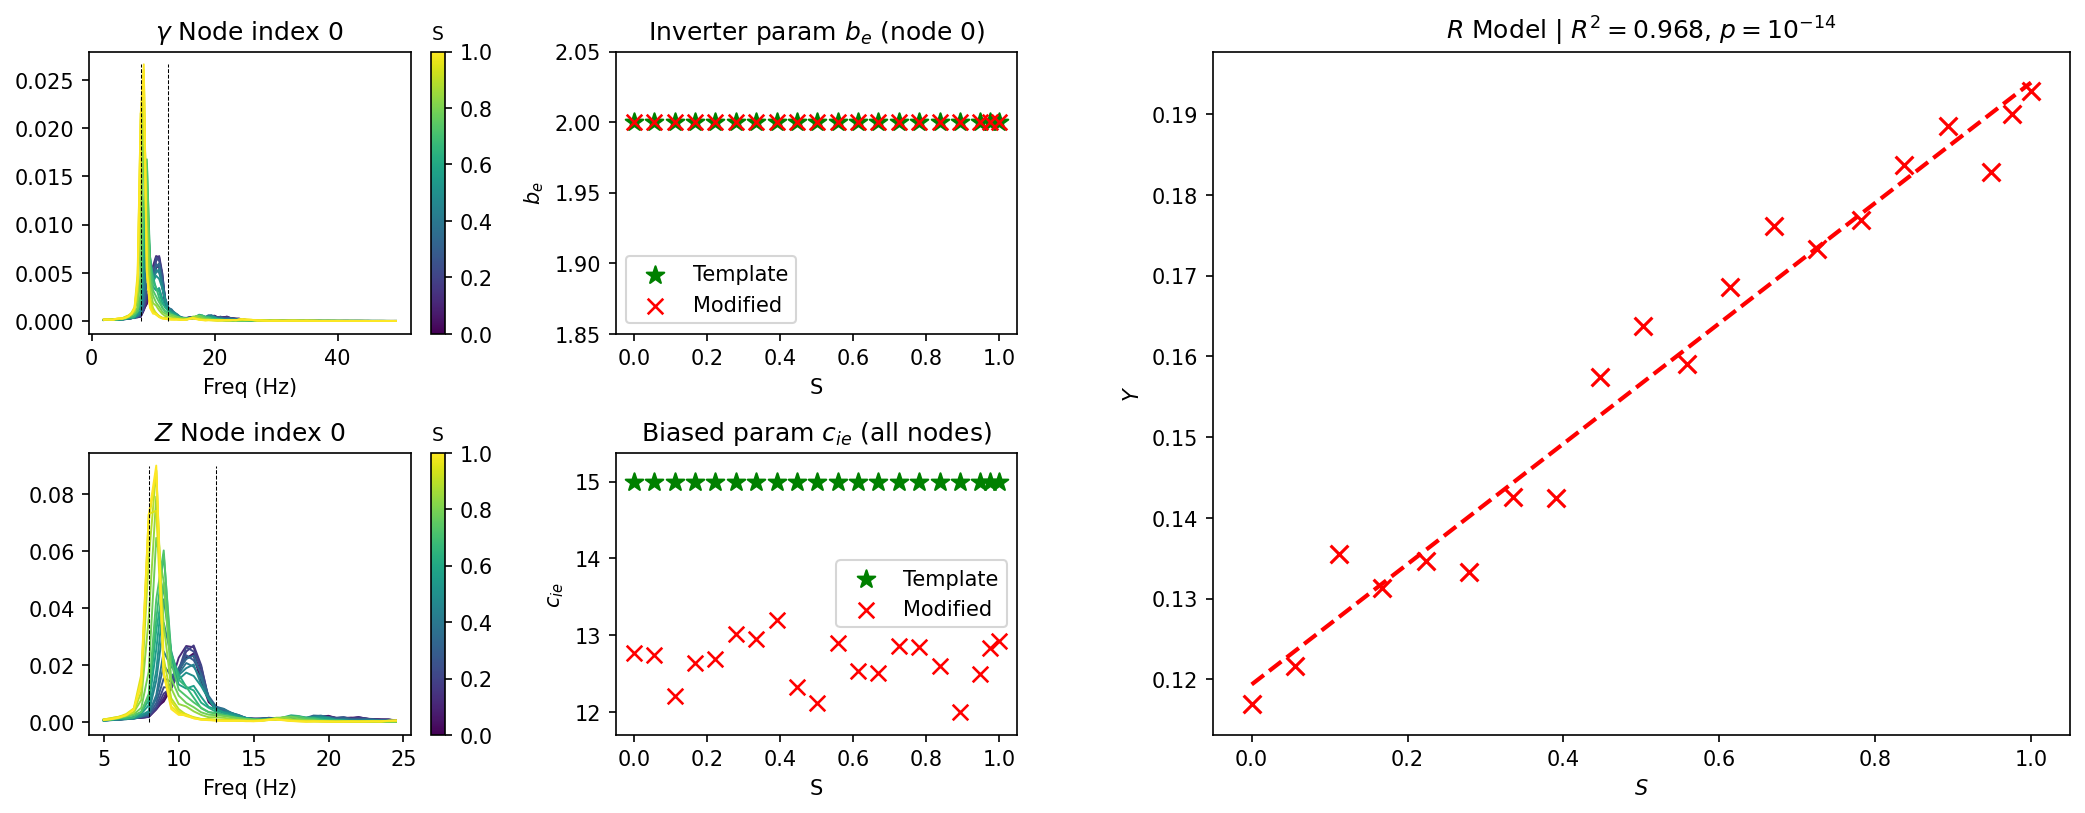

In [ ]:
produce_new_data,show_unaltered = False,True
random_M,newseed = False, False

dt = 2
length = 50
alpha_synth_gen = AlphaCoupledNetworkModel(
    n_nodes=n_nodes,
    bounds=parameter_bounds_gen,
    local_free_parameters=local_free_parameters,
    coupling_free_parameters=coupling_free_parameters,
    local_template=full_local_template_gen,
    coupling_template = full_coupling_template_gen,
    param_name_index_mapping=param_ind,
    verbose = 0

)
name_to_sampler_index = {}
for p in range(len(alpha_synth_gen.sample_params_correspondance)):
    if isinstance(alpha_synth_gen.sample_params_correspondance[p],int):
        if alpha_synth_gen.sample_params_correspondance[p] == -1:
            name_to_sampler_index["a"] = p
        elif alpha_synth_gen.sample_params_correspondance[p] == -1:
            name_to_sampler_index["K"] = p
    else:
        if alpha_synth_gen.sample_params_correspondance[p]["name"] not in name_to_sampler_index:
            name_to_sampler_index[alpha_synth_gen.sample_params_correspondance[p]["name"]] = p
base = alpha_synth_gen._generate_param_sample_of_template()
alter_relationship_index = 0
biased_param_index = 1
alter_relationship_index_excl = np.ones_like(base,dtype=bool)
alter_relationship_index_excl[alter_relationship_index] = False
base_params = alpha_synth_gen(base[None,...])[0]
n_param_dims=alpha_synth_gen.sample_dim
sample_range = alpha_synth_gen._get_formatted_bound(parameter_bounds)
sample_std = np.diff(alpha_synth_gen._get_formatted_bound(parameter_bounds_gen),axis=-1).squeeze()
synthetic_model = partial(sim_wrapper,model_fn=model_fn, model_kwargs=model_kwargs,psd_freq_indices=psd_freq_indices)
alter_relationship = 0
plot_gamma_dist , plot_gamma = plot_gamma_dist_coupl, partial(plot_gamma_coupl, summary=["index",0])
plot_Z_dist,plot_Z = plot_gamma_dist_coupl,partial(plot_gamma_coupl, summary=["index",0])
if produce_new_data:
    if newseed:
        ns = np.random.randint(0,1000)
    synthetic_data = {}
    thetas = np.zeros((n_samples,n_param_dims)) + broadcast_like(base,np.zeros((n_samples,n_param_dims)))
    if alter_relationship is not None and alter_relationship>0:
        thetas[:,alter_relationship_index] = thetas[:,alter_relationship_index] +  (S_F) * alter_relationship
    noise_values = np.random.normal(loc=0,scale=1, size = thetas[...,alter_relationship_index_excl].shape)
    noise_values[np.abs(noise_values)>2] = np.sign(noise_values[np.abs(noise_values)>2]) * 2
    thetas[...,alter_relationship_index_excl] = thetas[...,alter_relationship_index_excl]  + sample_std[...,alter_relationship_index_excl]/4 * noise_values
    synthetic_data_params = {
        "connectivity":S,
        "S":S,
        "M":M,
        "theta":thetas,
        "alpha":alpha_synth_gen,
        "full_params":alpha_synth_gen(thetas)
    }
    synthetic_data["gamma"] = synthetic_model(
                                                    **synthetic_data_params,
                                                    dt=dt,length=length,noise_seed =ns,
    )
    synthetic_data["S"] = S_F_fn(synthetic_data_params["S"])
    synthetic_data["S_full"] = synthetic_data_params["S"]

    synthetic_data["Y"] = [F_fn(synthetic_data["gamma"]) for F_fn in F_fns]
    synthetic_data["Z"] = T_fn(synthetic_data["gamma"])
    synthetic_data_summary_unaltered = {"data":dcp(synthetic_data),"params":dcp(synthetic_data_params)}
if not use_preexisting_data:
    thetas_og = dcp(synthetic_data_params["theta"])
else:
    synthetic_data = synthetic_data_unaltered
    synthetic_data_params = synthetic_data_unaltered_params
R_model = [{
    "model":r_model_type(**r_model_kwargs),
} for _ in range(len(F_fns))]
R_fn, Y_hat_R, epsilon_hat_R = [],[],[]
for i in range(len(F_fns)):
    R_model[i]["model"].fit(synthetic_data["S"],synthetic_data["Y"][i])
    R_fn.append(R_model[i]["model"].predict)
    Y_hat_R.append(R_fn[i](synthetic_data["S"]))
    epsilon_hat_R.append(synthetic_data["Y"][i]-Y_hat_R[i])
if show_unaltered:
    scatter_kwargs = {
        "cmap":"Reds",
        "edgecolors":"k",
        "s": 250/((n_samples)**(1/2)),
        "linewidths":1.25
    }
    n_cols_gamma = 4 
    n_rows_gamma = 2
    n_rows_y = (np.ceil(len(F_fns)/2 + 1e-4)).astype(int).item() 
    n_cols_y = (np.ceil(len(F_fns)/2)).astype(int).item() + 1
    counter_new_line_offfset = 5
    fig = plt.figure(figsize = (3.5*n_cols_gamma,2.75*n_rows_gamma), dpi = 150)
    counter = 1
    # Plot gamma set
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    set_plot_cmap(ax,synthetic_data["S"])
    title_add = plot_gamma(freqs_gamma,synthetic_data["gamma"], ax, n_samples)
    clb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=synthetic_data["S"].min(),vmax=synthetic_data["S"].max(), clip=True),cmap="viridis"), ax=ax)
    clb.ax.set_title('S',fontsize=9)
    plt.title("$\gamma$"+ title_add)

    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    param_name = (alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["name"])
    param_index = param_ind[param_name]
    delta_param = np.abs(synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]-param_[param_index])
    plt.scatter(
        synthetic_data["S"],
        np.zeros_like(synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]) + param_[param_index], 
        s = 350/((n_samples)**(1/2)),
        c="g",
        marker = "*",
        label="Template"
    )
    plt.scatter(
        synthetic_data["S"],
        (synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]), 
        c="r",
        marker = "x",
        label="Modified",
        **scatter_kwargs
    )
    allvals = np.array([param_[param_index]]+synthetic_data_params["theta"][:,name_to_sampler_index[param_name]].tolist())
    val_range = [allvals.min(),allvals.max()]
    plt.legend()
    plt.ylim(stretch_range(val_range,[0.925,1.025]))
    plt.xlabel("S")
    plt.ylabel(f"{parameter_latex_mapping_[parameter_names[param_index]]}")
    plt.title(f"Inverter param {parameter_latex_mapping_[parameter_names[param_index]]} (node 0)")

    # Plot Z Set    
    counter = counter_new_line_offfset
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    set_plot_cmap(ax,synthetic_data["S"])
    title_add = plot_Z(freqs_Z,synthetic_data["Z"], ax, n_samples)
    clb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=synthetic_data["S"].min(),vmax=synthetic_data["S"].max(), clip=True),cmap="viridis"), ax=ax)
    clb.ax.set_title('S',fontsize=9)
    plt.title("$Z$"+ title_add)
    # Plot Z dist
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    p = biased_param_index
    grouping = alpha_synth_gen.sample_params_correspondance[p]["grouping"]
    param_index = alpha_synth_gen.sample_params_correspondance[p]["template_index"]
    param_name = alpha_synth_gen.sample_params_correspondance[p]["name"]
    delta_param = np.abs(synthetic_data_params["theta"][:,p]-param_[param_index])
    plt.scatter(
        synthetic_data["S"],
        np.zeros_like(synthetic_data_params["theta"][:,p]) + param_[param_index], 
        s = 350/((n_samples)**(1/2)),
        c="g",
        marker = "*",
        label="Template"
    )
    plt.scatter(
        synthetic_data["S"],
        (synthetic_data_params["theta"][:,p]), 
        c="r",
        marker = "x",
        label="Modified",
        **scatter_kwargs
    )
    allvals = np.array([param_[param_index]]+synthetic_data_params["theta"][:,p].tolist())
    val_range = [allvals.min(),allvals.max()]
    plt.legend()
    plt.ylim(stretch_range(val_range,[0.975,1.025]))
    plt.xlabel("S")
    plt.ylabel(f"{parameter_latex_mapping_[param_name]}")
    plt.title(f"Biased param {parameter_latex_mapping_[param_name]} (all nodes)")
    plt.tight_layout()
    # Plot model with scatter
    counter = 2*np.floor(n_cols_y/2).astype(int)
    for i in range(len(F_fns)):
        ax = plt.subplot(n_rows_y,n_cols_y,counter)
        counter+=2*np.floor(n_cols_y/2).astype(int)
        euclidean_param_dist = np.ones_like(synthetic_data["S"])
        for p in range(len(alpha_synth_gen.sample_params_correspondance)):
            grouping = alpha_synth_gen.sample_params_correspondance[p]["grouping"]
            param_index = alpha_synth_gen.sample_params_correspondance[p]["template_index"]
            param_name = alpha_synth_gen.sample_params_correspondance[p]["name"]
            euclidean_param_dist += (synthetic_data_params["theta"][:,p]-param_[param_index])**2
        euclidean_param_dist = np.sqrt(euclidean_param_dist)
        local_scatter_kwargs = dcp(scatter_kwargs)
        if "s" in local_scatter_kwargs:
            local_scatter_kwargs.pop("s")
        plt.scatter(synthetic_data["S"],synthetic_data["Y"][i],s = 325/((n_samples)**(1/2)),
                     c="r",
                     marker="x",
                     label="Y",
            )
        plt.plot(synthetic_data["S"],Y_hat_R[i],"--r",lw=2., label="$\\hat{Y}$")
        plt.xlabel("$S$")
        plt.ylabel("$Y$")
        pval = R_model[i]["model"].p_value
        pval_str = ""
        if pval < 1e-3:
            pval = round(np.log10(max(pval,1e-300)))
            pval_str = "10^{"+f"{pval}"+"}$"
        else:
            pval = round(pval,3)
            pval_str=f"{pval}$"
        plt.title('$R$ Model | ' +f'$R^2={round(R_model[i]["model"].r_value,3)}$, $p={pval_str}')
    plt.show()

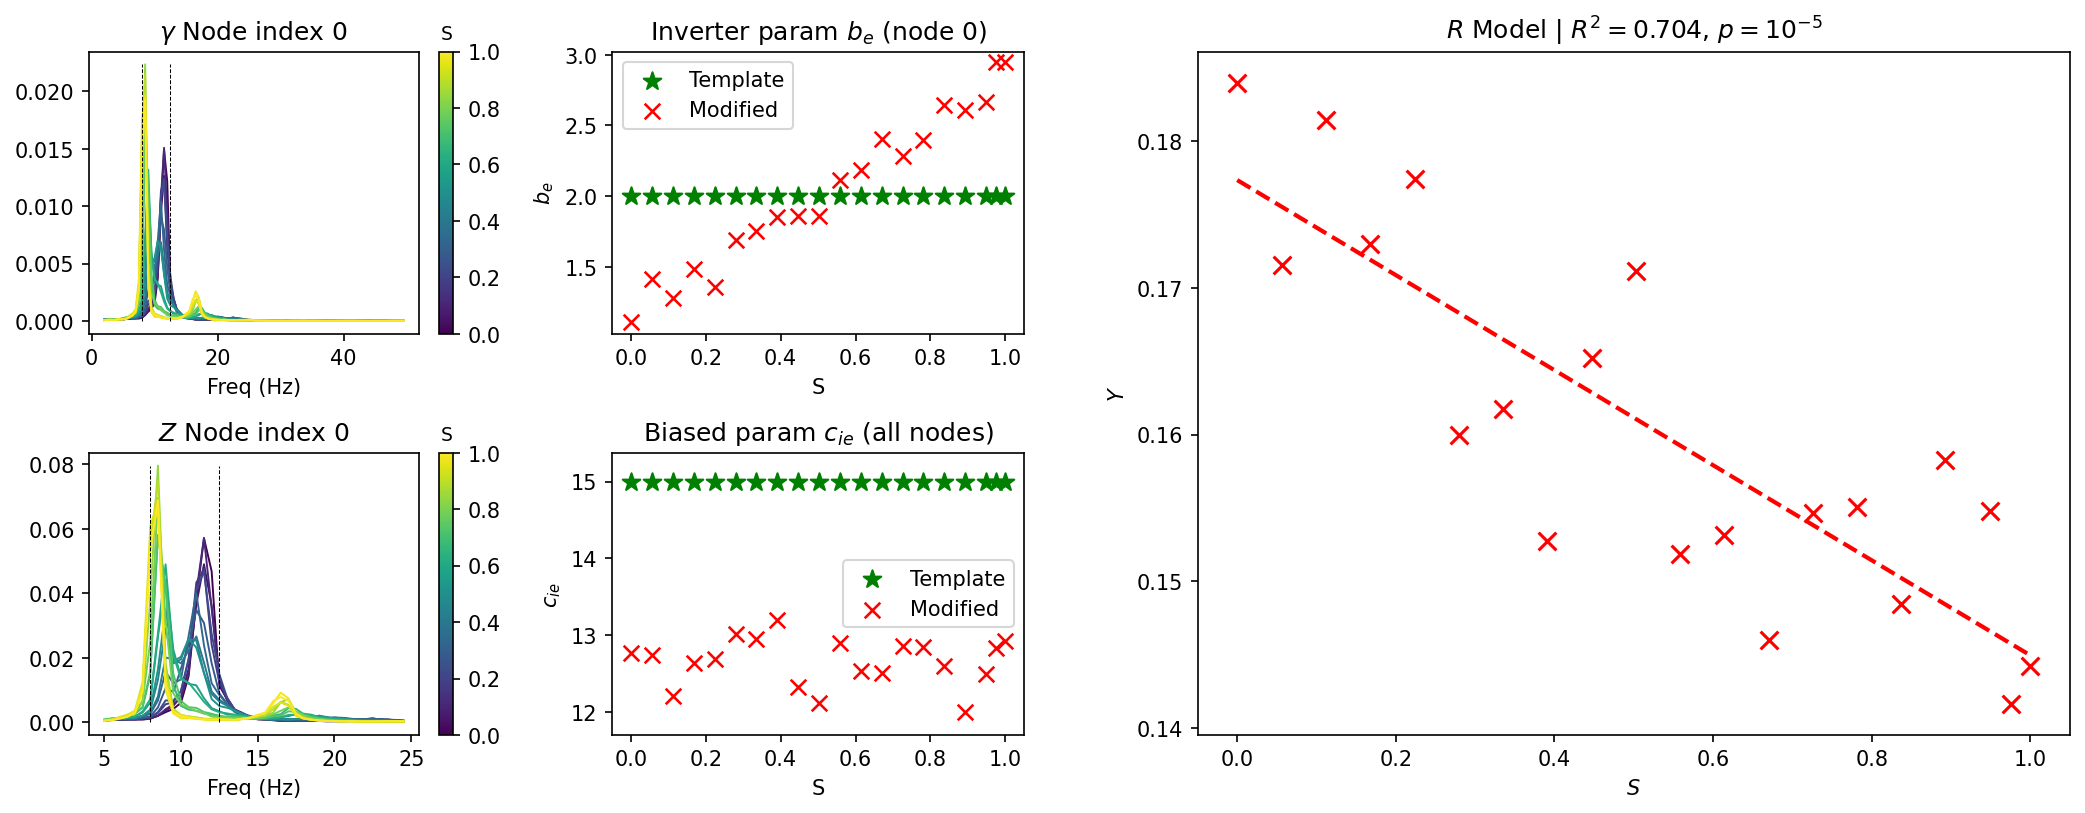

In [ ]:
show_altered,show_dist = True,False
alter_relationship,alter_offset = 1.75, -0.35
if produce_new_data:
    if newseed:
        ns = np.random.randint(0,1000)
    synthetic_data = {}
    thetas = dcp(thetas_og)
    if alter_relationship is not None and alter_relationship>0:
        templ_index = alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["template_index"]
        sampl_index = alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["sampler_index"]
        group_mask = alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["grouping"]
        alter_std = np.diff(alpha_synth_gen.bounds["local_params"][group_mask,alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["template_index"]])/4
        alter_full_range = np.diff(parameters_ranges_[alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["template_index"]])
        thetas[:,alter_relationship_index] = thetas[:,alter_relationship_index] +  (S_F) * alter_relationship + alter_full_range*alter_offset
        noise_values = np.random.normal(loc=0,scale=1, size = thetas[...,alter_relationship_index].shape)
        noise_values[np.abs(noise_values)>2] = np.sign(noise_values[np.abs(noise_values)>2]) * 2
        thetas[:,alter_relationship_index] = thetas[:,alter_relationship_index] + alter_std * noise_values
    synthetic_data_params = {
        "connectivity":S,
        "S":S,
        "M":M,
        "theta":thetas,
        "alpha":alpha_synth_gen,
        "full_params":alpha_synth_gen(thetas)
    }
    synthetic_data["gamma"] = synthetic_model(
                                                    **synthetic_data_params,
                                                    dt=dt,length=length,noise_seed =ns,
    )
    synthetic_data["S"] = S_F_fn(synthetic_data_params["S"])
    synthetic_data["S_full"] = synthetic_data_params["S"]

    synthetic_data["Y"] = [F_fn(synthetic_data["gamma"]) for F_fn in F_fns]
    synthetic_data["Z"] = T_fn(synthetic_data["gamma"])
    synthetic_data_summary_altered = {"data":dcp(synthetic_data),"params":dcp(synthetic_data_params)}

if use_preexisting_data:
    synthetic_data = synthetic_data_altered
    synthetic_data_params = synthetic_data_altered_params

R_model = [{
    "model":r_model_type(**r_model_kwargs),
} for _ in range(len(F_fns))]
R_fn, Y_hat_R, epsilon_hat_R = [],[],[]
for i in range(len(F_fns)):
    R_model[i]["model"].fit(synthetic_data["S"],synthetic_data["Y"][i])
    R_fn.append(R_model[i]["model"].predict)
    Y_hat_R.append(R_fn[i](synthetic_data["S"]))
    epsilon_hat_R.append(synthetic_data["Y"][i]-Y_hat_R[i])
if show_altered:
    scatter_kwargs = {
        "cmap":"Reds",
        "edgecolors":"k",
        "s": 250/((n_samples)**(1/2)),
        "linewidths":1.25
    }
    n_cols_gamma = 4 
    n_rows_gamma = 2
    n_rows_y = (np.ceil(len(F_fns)/2 + 1e-4)).astype(int).item() 
    n_cols_y = (np.ceil(len(F_fns)/2)).astype(int).item() + 1
    counter_new_line_offfset = 5
    fig = plt.figure(figsize = (3.5*n_cols_gamma,2.75*n_rows_gamma), dpi = 150)
    counter = 1
    # Plot gamma set
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    set_plot_cmap(ax,synthetic_data["S"])
    title_add = plot_gamma(freqs_gamma,synthetic_data["gamma"], ax, n_samples)
    clb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=synthetic_data["S"].min(),vmax=synthetic_data["S"].max(), clip=True),cmap="viridis"), ax=ax)
    clb.ax.set_title('S',fontsize=9)
    plt.title("$\gamma$"+ title_add)

    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    param_name = (alpha_synth_gen.sample_params_correspondance[alter_relationship_index]["name"])
    param_index = param_ind[param_name]
    delta_param = np.abs(synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]-param_[param_index])
    plt.scatter(
        synthetic_data["S"],
        np.zeros_like(synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]) + param_[param_index], 
        s = 350/((n_samples)**(1/2)),
        c="g",
        marker = "*",
        label="Template"
    )
    plt.scatter(
        synthetic_data["S"],
        (synthetic_data_params["theta"][:,name_to_sampler_index[param_name]]), 
        c="r",
        marker = "x",
        label="Modified",
        **scatter_kwargs
    )
    allvals = np.array([param_[param_index]]+synthetic_data_params["theta"][:,name_to_sampler_index[param_name]].tolist())
    val_range = [allvals.min(),allvals.max()]
    plt.legend()
    plt.ylim(stretch_range(val_range,[0.925,1.025]))
    plt.xlabel("S")
    plt.ylabel(f"{parameter_latex_mapping_[parameter_names[param_index]]}")
    plt.title(f"Inverter param {parameter_latex_mapping_[parameter_names[param_index]]} (node 0)")#

    # Plot Z Set    
    counter = counter_new_line_offfset
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    set_plot_cmap(ax,synthetic_data["S"])
    title_add = plot_Z(freqs_Z,synthetic_data["Z"], ax, n_samples)
    clb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=synthetic_data["S"].min(),vmax=synthetic_data["S"].max(), clip=True),cmap="viridis"), ax=ax)
    clb.ax.set_title('S',fontsize=9)
    plt.title("$Z$"+ title_add)
    # Plot Z dist
    ax = plt.subplot(n_rows_gamma,n_cols_gamma,counter)
    counter+=1
    p = biased_param_index
    grouping = alpha_synth_gen.sample_params_correspondance[p]["grouping"]
    param_index = alpha_synth_gen.sample_params_correspondance[p]["template_index"]
    param_name = alpha_synth_gen.sample_params_correspondance[p]["name"]
    delta_param = np.abs(synthetic_data_params["theta"][:,p]-param_[param_index])
    plt.scatter(
        synthetic_data["S"],
        np.zeros_like(synthetic_data_params["theta"][:,p]) + param_[param_index], 
        s = 350/((n_samples)**(1/2)),
        c="g",
        marker = "*",
        label="Template"
    )
    plt.scatter(
        synthetic_data["S"],
        (synthetic_data_params["theta"][:,p]), 
        #c=delta_param,
        c="r",
        marker = "x",
        label="Modified",
        **scatter_kwargs
    )
    allvals = np.array([param_[param_index]]+synthetic_data_params["theta"][:,p].tolist())
    val_range = [allvals.min(),allvals.max()]
    plt.legend()
    plt.ylim(stretch_range(val_range,[0.975,1.025]))
    plt.xlabel("S")
    plt.ylabel(f"{parameter_latex_mapping_[param_name]}")
    plt.title(f"Biased param {parameter_latex_mapping_[param_name]} (all nodes)")
    plt.tight_layout()
    # Plot model with scatter
    counter = 2*np.floor(n_cols_y/2).astype(int)
    for i in range(len(F_fns)):
        ax = plt.subplot(n_rows_y,n_cols_y,counter)
        counter+=2*np.floor(n_cols_y/2).astype(int)
        euclidean_param_dist = np.ones_like(synthetic_data["S"])
        for p in range(len(alpha_synth_gen.sample_params_correspondance)):
            grouping = alpha_synth_gen.sample_params_correspondance[p]["grouping"]
            param_index = alpha_synth_gen.sample_params_correspondance[p]["template_index"]
            param_name = alpha_synth_gen.sample_params_correspondance[p]["name"]
            euclidean_param_dist += (synthetic_data_params["theta"][:,p]-param_[param_index])**2
        euclidean_param_dist = np.sqrt(euclidean_param_dist)
        local_scatter_kwargs = dcp(scatter_kwargs)
        if "s" in local_scatter_kwargs:
            local_scatter_kwargs.pop("s")
        plt.scatter(synthetic_data["S"],synthetic_data["Y"][i],s = 325/((n_samples)**(1/2)),
                     c="r",
                     marker="x",
                     label="Y",
            )
        plt.plot(synthetic_data["S"],Y_hat_R[i],"--r",lw=2., label="$\\hat{Y}$")
        plt.xlabel("$S$")
        plt.ylabel("$Y$")
        pval = R_model[i]["model"].p_value
        pval_str = ""
        if pval < 1e-3:
            pval = round(np.log10(max(pval,1e-300)))
            pval_str = "10^{"+f"{pval}"+"}$"
        else:
            pval = round(pval,3)
            pval_str=f"{pval}$"
        plt.title('$R$ Model | ' +f'$R^2={round(R_model[i]["model"].r_value,3)}$, $p={pval_str}')
    plt.show()

In [ ]:
# Saving the synthetic data if needed
if not use_preexisting_data and save_data:
    experiment_data = {
    "synthetic_data_summary_unaltered":synthetic_data_summary_unaltered,
    "synthetic_data_summary_altered":synthetic_data_summary_altered
    }
    save_log_(
        experiment_data,
        "./synthetic_data/",
        "experiment2_synthetic_data"
    )

In [34]:
synthetic_params_full_format = np.concatenate([synthetic_data_params["alpha"](synthetic_data_params["theta"])[i]["parameters"][None,...] for i in range(len(synthetic_data_params["theta"]))],axis=0)

# Implementing the framework

In [ ]:
def model_fn_wrapper(model_fn, psd_freq_indices=[4,50],**kwargs):
    try:
        output = model_fn(**kwargs)
        if isinstance(output,list):
            output = output[0]
        return [output[...,psd_freq_indices[0]:psd_freq_indices[1]].squeeze()]
    except:
        return model_fn(**kwargs)#.squeeze()

### Specifying the hypotheses

In [ ]:
alpha_hypotheses_args = {
    "U: $\\alpha_1$":{
        "local_free_parameters":{
            "c_ie":[[i for i in range(bias_node_start,bias_node_start+nbias_nodes)]]
        },
        "coupling_free_parameters":[]
    },
    "U: $\\alpha_2$":{
        "local_free_parameters":{
            "theta_e":[[0]]
        },
        "coupling_free_parameters":[]
    },
    "T: $\\alpha_3$":{
        "local_free_parameters":{
            "theta_e":[[0]],
            "c_ie":[i for i in range(bias_node_start,bias_node_start+nbias_nodes)]
        },
        "coupling_free_parameters":[]
    },
    "O: $\\alpha_4$":{
        "local_free_parameters":{
            "theta_e":[[i] for i in range(n_nodes)],
            "c_ie":[[i] for i in range(n_nodes)]
        },
        "coupling_free_parameters":[]
    },
    "O: $\\alpha_5$":{
        "local_free_parameters":{
            
            p:[i for i in range(0,n_nodes)]
            for p in param_ind
        },
        "coupling_free_parameters":[]
    },
    "M: $\\alpha_6$":{
        "local_free_parameters":{
            "theta_e":[i for i in range(n_nodes)],
            "c_ie":[i for i in range(n_nodes)]
        },
        "coupling_free_parameters":[]
    },
}
alpha_hypotheses_ = {
    h_n: AlphaCoupledNetworkModel(
                                    n_nodes=n_nodes,
                                    bounds=parameter_bounds,
                                    local_template=full_local_template,
                                    coupling_template = coupling_template,
                                    param_name_index_mapping=param_ind,
                                    verbose = 0,
                                    **alpha_hypotheses_args[h_n]
        )
        for h_n in alpha_hypotheses_args
}
phi_model = {f"{h_n}({alpha_hypotheses_[h_n].sample_dim})":{"alpha":alpha_hypotheses_[h_n]} for h_n in alpha_hypotheses_args}
length = 25
for index,h_n in enumerate(phi_model):
    phi_model[h_n]["model"] =  partial(
        model_fn_wrapper,
        model_fn=model_fn,
        psd_freq_indices=psd_freq_indices,
        length = length,
        **model_kwargs
    )
    phi_model[h_n]["prior_uniform"] = uniform_prior
    phi_model[h_n]["prior"] = phi_model[h_n]["prior_uniform"]

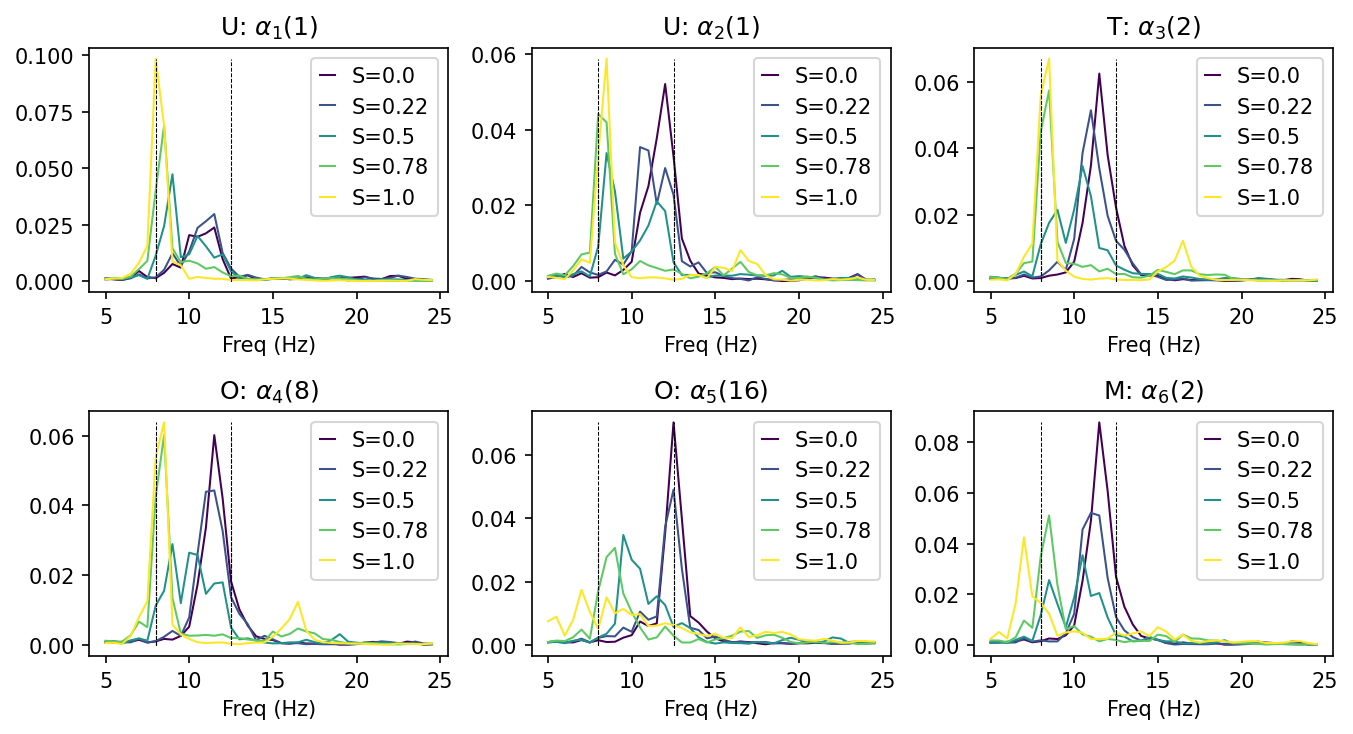

In [ ]:
freqs_plot_Z = freqs_Z
samples_plot = 1
plot_mask = np.linspace(0,synthetic_data["S"].shape[0]-1,5,dtype=int)
c = ["r","k"]
n_cols = 3
n_rows= 2
for s in range(samples_plot):
    fig = plt.figure(figsize=(3*n_cols,(2.5*n_rows)),dpi=150)
    counter = 1
    for a, alpha_sel in enumerate(phi_model):
        theta_random_perturb = (phi_model[alpha_sel]["alpha"].formatted_max-phi_model[alpha_sel]["alpha"].formatted_min) * np.random.normal(size=phi_model[alpha_sel]["alpha"].formatted_min.shape)/(50 - ((25*s)/(samples_plot)))
        ax = plt.subplot(n_rows,n_cols,counter)
        ax = set_plot_cmap(ax, bounds = [0,1,len(plot_mask)])
        errs = ""
        counter+=1
        for sv,i in enumerate(plot_mask):
            theta_random = phi_model[alpha_sel]["alpha"]._generate_param_sample_from_full(synthetic_data_params["full_params"][i]) + theta_random_perturb
            params_rand = phi_model[alpha_sel]["alpha"](theta_random[None,...])[0]
            z = T_fn(phi_model[alpha_sel]["model"](connectivity=synthetic_data["S_full"][i],**params_rand)[0])
            plot_Z(freqs_Z,z[None,...],ax=ax,n_samples=len(plot_mask),label = f"S={round(synthetic_data['S'][i],2)}")
        plt.legend(handlelength=0.75,fontsize=10)
        plt.title(alpha_sel.split("__")[-1])
plt.tight_layout()
plt.show()

In [ ]:
# Gotta love abstraction...
def combine_gof_fns(x):
    return  (x.squeeze(-1)**(1))
def cond_samp(sampler:BaseSampler,round_width):
    if round_width<=0.5:
        sampler.set_sampling_method("cube")
    elif round_width>=0.9:
        sampler.set_sampling_method("full_cube")
    else:
        sampler.set_sampling_method("cube")
def gof_wrapper(model_output,data_sample_features,formatting=None):
    formatted_output = formatting["psd"](model_output[0])
    Y,Y_model = mnt.ensure_numpy(data_sample_features[0]), mnt.ensure_numpy(formatted_output)
    gof_vals = mnt.ensure_torch(ssmre_likelihood_fn(Y,Y_model))[...,None]
    return gof_vals
gof = gof_wrapper
combine_gofs = combine_gof_fns

In [ ]:
max_jobs, parallelize_sim = 1, False
use_template_as_center = True
init_sample_ratio_ = 0.4
default_parameters = {
    "n_rounds":40,
    "temperature":1e-3,
    "init_sample_ratio":init_sample_ratio_,
    "search_width":0.05,
    "search_max_width":0.25,
    "gof_Z":ssmre_likelihood_fn,
    "gof": gof_wrapper,
    "Y_pdf":ssmre_likelihood_fn,
    "n_samples":5000,
    "prior_fn":"prior_uniform",
    "round_width_fn": partial(round_width_cosine_decay,decay = 5),
    "expectation_fn":approximate_expected_from_finite_theta_sample_set
}
def modify_params(params_dict,index):
    if index == 0 :
        params_dict["expectation_fn"] = approximate_expected_from_finite_theta_sample_set
    elif index == 1:
        params_dict["expectation_fn"] = partial(approximate_expected_from_finite_theta_sample_set_with_rejection,reference_gof_type="median")
    elif index == 2:
        params_dict["expectation_fn"] = partial(approximate_expected_from_finite_theta_sample_set_with_rejection,reference_gof_type="quantile-0.75")
    return params_dict
experiments = [
        {"results":None,"parameters":modify_params(dcp(default_parameters),index),"info":{"name":f"Efn{index}_run{r}"}} for index in [0]
        for r in range(1)
]
dict_jobs = []
results_indexing = np.zeros((len(experiments),len(phi_model),n_samples),dtype=int)
count = 0
for e, experiment in enumerate(experiments):
    n_rounds = experiments[e]["parameters"]["n_rounds"]
    init_sample_ratio = experiments[e]["parameters"]["init_sample_ratio"]
    search_width = experiments[e]["parameters"]["search_width"]
    search_max_width = experiments[e]["parameters"]["search_max_width"]
    temperature = experiments[e]["parameters"]["temperature"]
    gof_Z = experiments[e]["parameters"]["gof_Z"]
    gof_ = experiments[e]["parameters"]["gof"]
    epsilon_Y_tilde_pdf = experiments[e]["parameters"]["Y_pdf"]
    n_param_samples = experiments[e]["parameters"]["n_samples"]
    prior_fn = experiments[e]["parameters"]["prior_fn"]
    round_width_fn = experiments[e]["parameters"]["round_width_fn"]
    expectation_fn =  experiments[e]["parameters"]["expectation_fn"]
    delta_Z_tilde_pdf = gof_Z
    
    for a, alpha_sel in enumerate(phi_model):
        center = None
        if use_template_as_center:
            center = phi_model[alpha_sel]["alpha"]._generate_param_sample_of_template()
        for s in range(n_samples):
            T_features = {"psd":synthetic_data["gamma"][s][None,...]}

            formatting_fns = {"psd":T_fn}
            T_features_shape = {feature:list(formatting_fns[feature](synthetic_data["gamma"][s][None,...][0]).shape) for feature in formatting_fns}
            dataset = DataSample(
                T_features=T_features,T_feature_shapes=T_features_shape, data_sample_formatting=formatting_fns
            )

            sampler = CoupledNetworkModelSampler(
                model = phi_model[alpha_sel]["model"],
                alpha=phi_model[alpha_sel]["alpha"],
                data_sample_set=dataset,
                S=synthetic_data["S"][s],
                connectivity=synthetic_data["S_full"][s],
                model_kwargs={},
                gof = gof_,
                combine_gofs=combine_gofs,
                dt = dt,length=phi_model[alpha_sel]["model"].keywords["length"],
                max_jobs=max_jobs,
                parallelize_sim = parallelize_sim,
                verbose =  0

            )
            SA_sampler = SimulatedAnnealingSamplerCoupledNetwork(
                model_sampler=sampler,
                theta_center = center,
                n_rounds = n_rounds,
                init_sample_ratio=init_sample_ratio,
                search_max_width=search_max_width,
                search_width=search_width,
                temperature=temperature,
                round_width_fn = round_width_fn,
                parallelize_sim=parallelize_sim
                
                
            )
            Y_hat_RFs = [Y_hat_R_f[s] for Y_hat_R_f in Y_hat_R]
            dict_jobs.append(dict(
                                    S=synthetic_data["S_full"][s],
                                    Z=synthetic_data["Z"][s],
                                    model=phi_model[alpha_sel]["model"],
                                    n_samples=n_param_samples,
                                    theta_sampler=SA_sampler,
                                    F_fn=F_fns,T_fn=T_fn,
                                    gof_fn=gof_Z,
                                    theta_sampler_kwargs = {},
                                    prior_fn = phi_model[alpha_sel][prior_fn],
                                    expectation_fn = expectation_fn, 
            ))
            results_indexing[e,a,s] = count
            count+=1
results = parallelize(expectation_over_parameter_space,dict_jobs,verbose = 0,n_jobs=23)
for e, experiment in enumerate(experiments):
    n_rounds = experiments[e]["parameters"]["n_rounds"]
    init_sample_ratio = experiments[e]["parameters"]["init_sample_ratio"]
    search_width = experiments[e]["parameters"]["search_width"]
    search_max_width = experiments[e]["parameters"]["search_max_width"]
    temperature = experiments[e]["parameters"]["temperature"]
    gof_Z = experiments[e]["parameters"]["gof_Z"]
    epsilon_Y_tilde_pdf = experiments[e]["parameters"]["Y_pdf"]
    n_param_samples = experiments[e]["parameters"]["n_samples"]
    prior_fn = experiments[e]["parameters"]["prior_fn"]
    round_width_fn = experiments[e]["parameters"]["round_width_fn"]
    expectation_fn =  experiments[e]["parameters"]["expectation_fn"]
    delta_Z_tilde_pdf = gof_Z

    model_evidence = np.zeros((len(F_fns),len(phi_model,)))
    model_evidence_Ts = np.zeros((len(phi_model,),n_samples))
    model_evidence_features_of_Ts = np.zeros((len(phi_model,),synthetic_data["Z"].shape[-1]))
    Z_tilde = np.zeros((len(phi_model,),*synthetic_data["Z"].shape))
    Y_tilde = [np.zeros((len(phi_model,),*synthetic_data["Y"][f].shape)) for f in range(len(F_fns))]
    theta_samples_dicts = [[None for _ in range(n_samples)] for _ in range(len(phi_model))]
    theta_samples = dcp(theta_samples_dicts)
    gofs = dcp(theta_samples_dicts)
    for a, alpha_sel in enumerate(phi_model):
        for s in range(n_samples):
            theta_samples_dicts[a][s] = results[results_indexing[e,a,s]]
            theta_samples[a][s] = results[results_indexing[e,a,s]]["theta_samples"]
            gofs[a][s] = results[results_indexing[e,a,s]]["gof"]
            Z_tilde[a,s] = theta_samples_dicts[a][s]["expected_Z_tilde"]
            for f in range(len(F_fns)):
                Y_tilde[f][a,s] = theta_samples_dicts[a][s]["expected_Y_tilde"][f]
            model_evidence_Ts[a,s] = -np.log10(max(1e-250,delta_Z_tilde_pdf(synthetic_data["Z"][s],Z_tilde[a,s])))
        for t_metric in range(model_evidence_features_of_Ts.shape[-1]):
            model_evidence_features_of_Ts[a,t_metric] =  -np.log10(max(1e-250,delta_Z_tilde_pdf(synthetic_data["Z"][...,t_metric],Z_tilde[a,...,t_metric])))
        for f in range(len(F_fns)):
            model_evidence[f,a] = -np.log10(max(1e-250,epsilon_Y_tilde_pdf(Y_tilde[f][a],synthetic_data["Y"][f])))
    experiments[e]["results"] = dict(
        gof_Z = gof_Z,
        epsilon_Y_tilde_pdf = epsilon_Y_tilde_pdf,
        delta_Z_tilde_pdf = delta_Z_tilde_pdf,
        model_evidence = model_evidence,
        model_evidence_Ts = model_evidence_Ts,
        model_evidence_features_of_Ts = model_evidence_features_of_Ts,
        Z_tilde = Z_tilde,
        Y_tilde = Y_tilde,
        samples = theta_samples,
        gofs = gofs,
        theta_samples_dicts = theta_samples_dicts,
    )

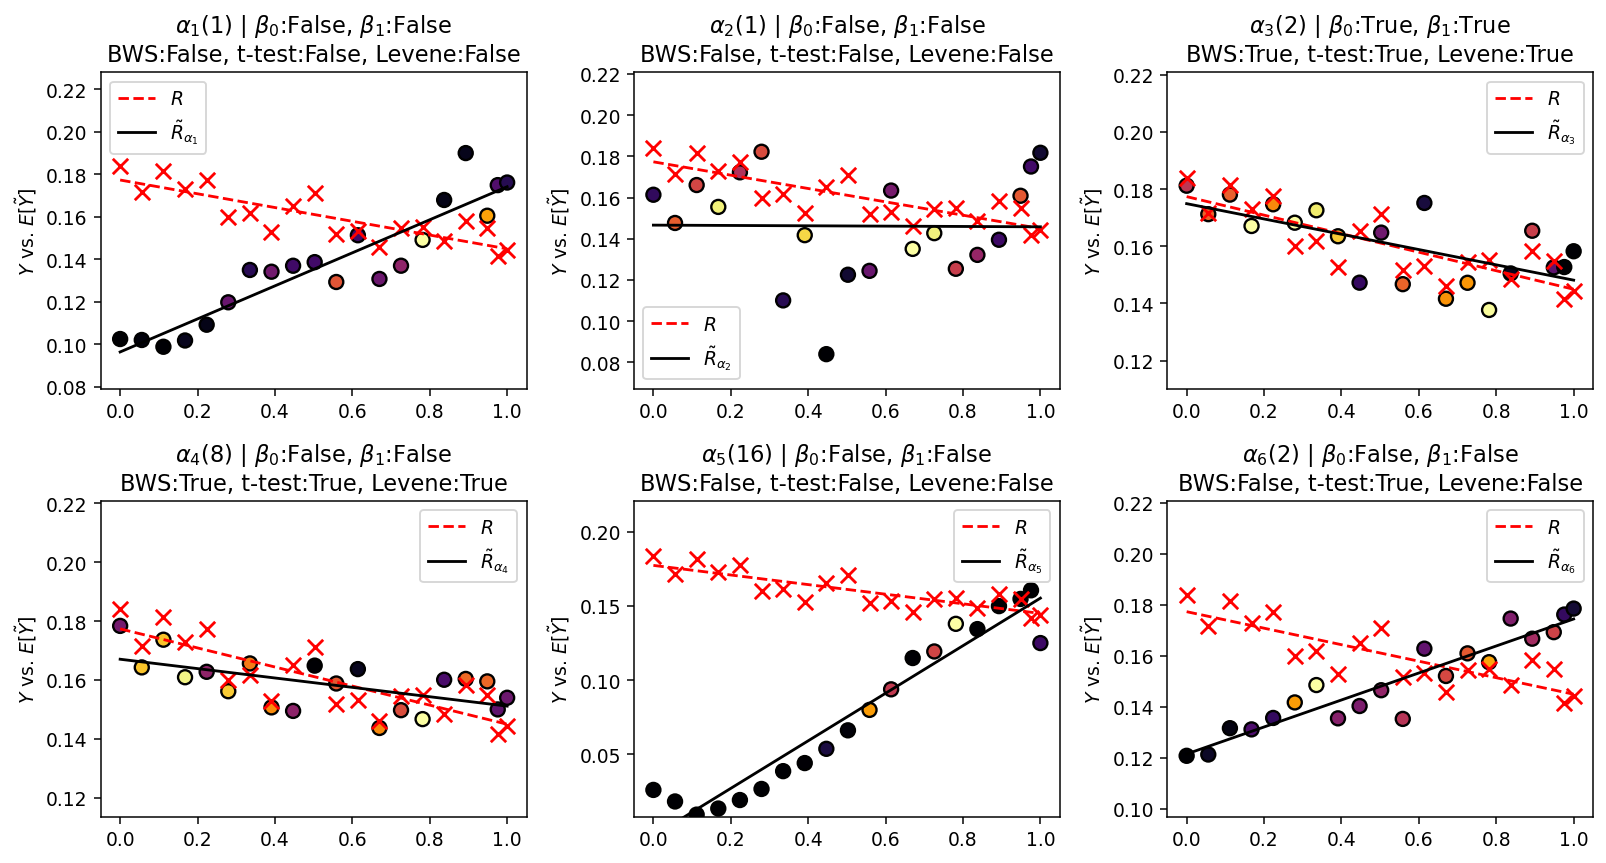

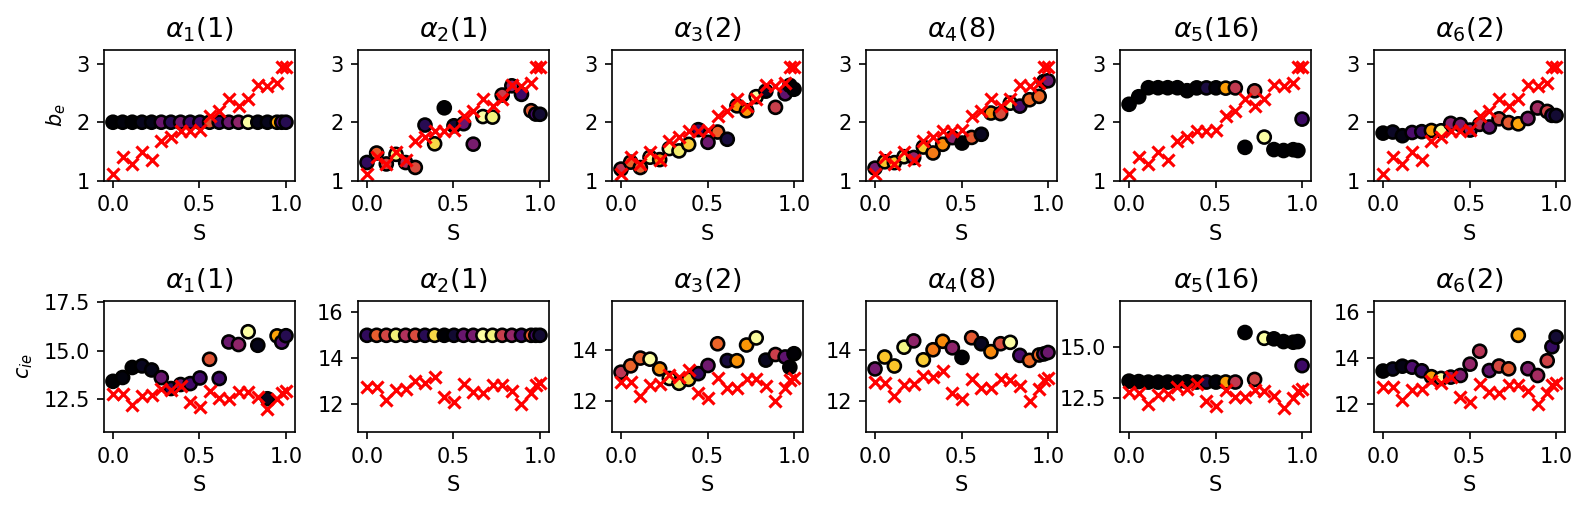

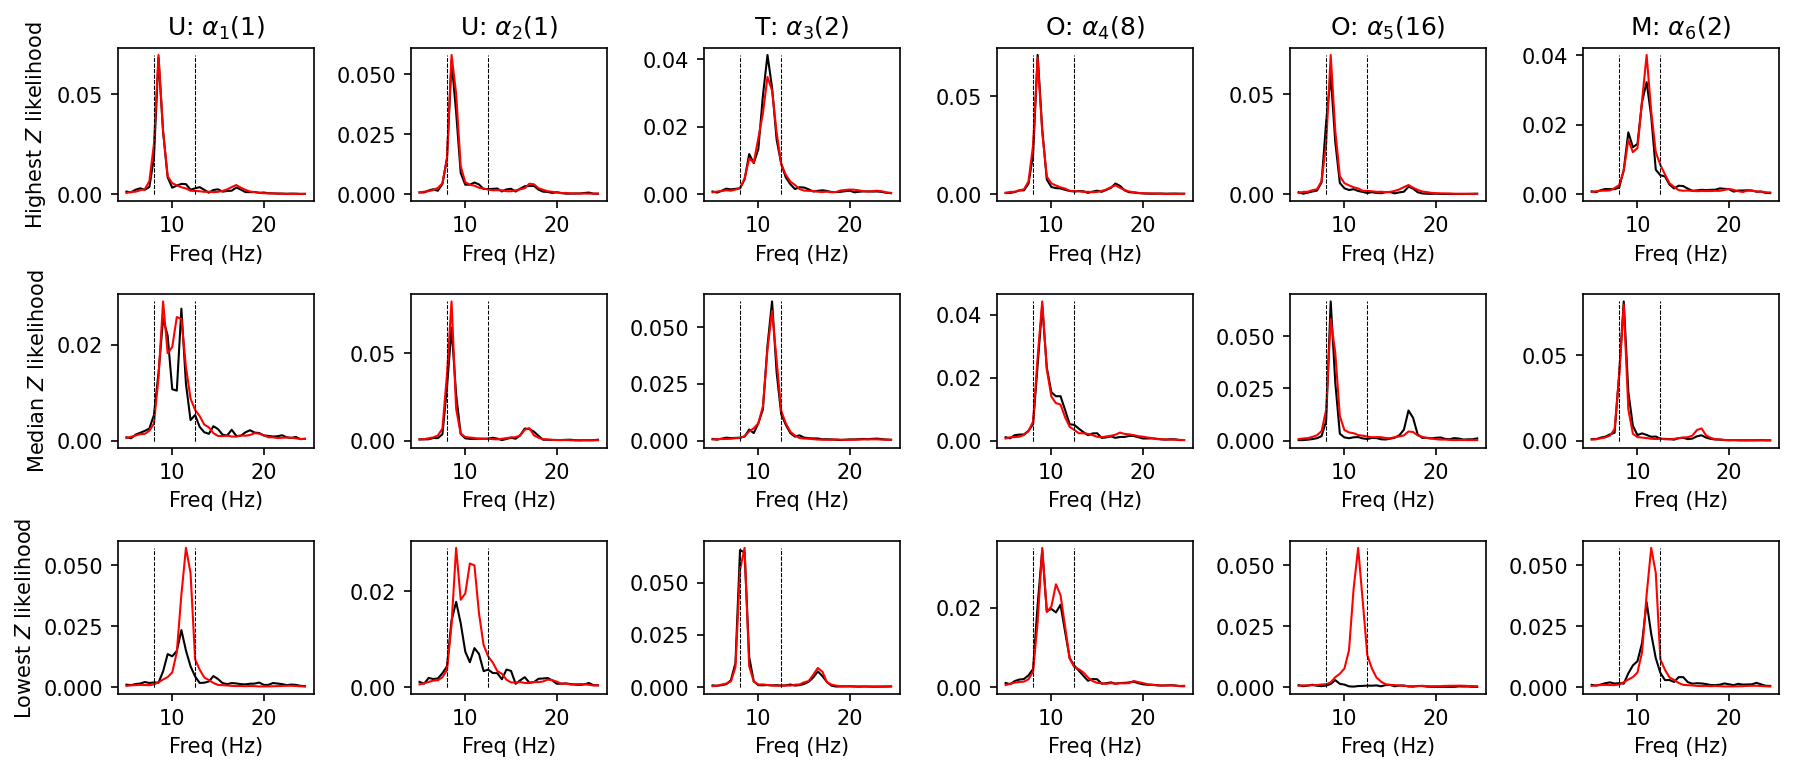

In [ ]:
F_fns_sel = [0] 
max_cols = 3
for experiment_index in range(len(experiments)):
    gof_Z, delta_Z_tilde_pdf,epsilon_Y_tilde_pdf,model_evidence,model_evidence_Ts,model_evidence_features_of_Ts,Z_tilde,Y_tilde,samples,gofs,theta_samples_dicts = [experiments[experiment_index]["results"][r] for r in experiments[experiment_index]["results"]]
    stats_test_overall = bws_test
    stats_test_mean = ttest_rel
    stats_test_var = levene
    fac = 0.5
    n_cols = min(max_cols,len(phi_model))
    n_rows = np.ceil(len(phi_model) * len(F_fns_sel)/n_cols).astype(int)
    
    fig = plt.figure(figsize=((4.*n_cols,3.25*(n_rows))),dpi = 135)
    counter = 1
    plot_order = np.arange(model_evidence[0].shape[0])
    for a in plot_order:
        alpha_sel = list(phi_model.keys())[a]
        ylab = True
        scatter_kwargs = {
            "cmap":"inferno",
            "edgecolors":"k",
            "s": 250/((n_samples)**(1/2)),
            "linewidths":1.25
        }
        for F_fn_look in F_fns_sel:
            epsilon_Y_tilde = Y_tilde[F_fn_look][a] - synthetic_data["Y"][F_fn_look][None,...]
            max_epsilon_Y_tilde = np.abs(epsilon_Y_tilde).max()
            normalized_epsilon_Y_tilde = epsilon_Y_tilde/max_epsilon_Y_tilde
            evidence_Z_tilde = np.array([delta_Z_tilde_pdf(synthetic_data["Z"][s], Z_tilde[a][s]) for s in range(n_samples)])
            ax = plt.subplot(n_rows,n_cols,counter)
            counter+=1
            
            expected_epsilon_tilde = synthetic_data["Y"][F_fn_look] - Y_tilde[F_fn_look][a]
            R_tilde_model = {
            "model":r_model_type(**r_model_kwargs),
            "model_bias_corrected":r_model_type(**r_model_kwargs)
            }
            R_tilde_model["model"].fit(synthetic_data["S"],Y_tilde[F_fn_look][a])
            R_tilde_model["model_bias_corrected"].fit(synthetic_data["S"],synthetic_data["Y"][F_fn_look])
            lfit = OLSResults(
                            OLS(
                                R_tilde_model["model_bias_corrected"]._prepareY(Y_tilde[F_fn_look][a]),
                                R_tilde_model["model_bias_corrected"]._prepareX(synthetic_data["S"])
                            ), 
                            R_tilde_model["model_bias_corrected"].model_object.params,
                            normalized_cov_params=R_tilde_model["model_bias_corrected"].model_object.normalized_cov_params
            )
            rfit = OLSResults(
                            OLS(
                                R_tilde_model["model"]._prepareY(synthetic_data["Y"][F_fn_look]),
                                R_tilde_model["model"]._prepareX(synthetic_data["S"])
                            ), 
                            R_tilde_model["model"].model_object.params,
                            normalized_cov_params=R_tilde_model["model"].model_object.normalized_cov_params
            )
            cross_pvals = [rfit.f_pvalue,lfit.f_pvalue]
            

            Y_hat_tilde_RT = R_tilde_model["model"].predict(synthetic_data["S"])
            Y_hat_tilde_RT_bias_corrected = R_tilde_model["model_bias_corrected"].predict(synthetic_data["S"])
            epsilon_hat_tilde_RT = Y_tilde[F_fn_look][a] - Y_hat_tilde_RT
            delta_Y_hat = (Y_hat_R[F_fn_look] - Y_hat_tilde_RT)
            epsilon_bar_RT = (synthetic_data["Y"][F_fn_look] - Y_hat_tilde_RT)
            epsilon_bar_RT_bias_corrected = (synthetic_data["Y"][F_fn_look] - Y_hat_tilde_RT_bias_corrected)
            epsilon_bar_R = (Y_tilde[F_fn_look][a]  - Y_hat_R[F_fn_look] )
            delta_epsilon_hat = epsilon_hat_tilde_RT - epsilon_hat_R[F_fn_look]
            if ylab:
                plt.ylabel("$Y$ vs. $E[\\tilde{Y}]$")
                ylab = False
                hypothesis_number = alpha_sel.split("__")[-1].split("$")[1]
            ks_res = stats_test_overall(epsilon_hat_R[F_fn_look],epsilon_bar_RT)
            t_res = stats_test_mean(epsilon_hat_R[F_fn_look],epsilon_bar_RT)
            var_res = stats_test_var(epsilon_hat_R[F_fn_look],epsilon_bar_RT)
            ks_res_tilde_bias_corrected =  stats_test_overall(epsilon_hat_R[F_fn_look],epsilon_bar_RT_bias_corrected)
            t_res_tilde_bias_corrected = stats_test_mean(epsilon_hat_R[F_fn_look],epsilon_bar_RT_bias_corrected)
            var_res_tilde_bias_corrected = stats_test_var(epsilon_hat_R[F_fn_look],epsilon_bar_RT_bias_corrected)
            R_params_bounds = [R_model[F_fn_look]["model"].model_object.params - R_model[F_fn_look]["model"].model_object.bse,R_model[F_fn_look]["model"].model_object.params + R_model[F_fn_look]["model"].model_object.bse]
            R_tilde_params_bounds = [R_tilde_model["model"].model_object.params - R_tilde_model["model"].model_object.bse,R_tilde_model["model"].model_object.params + R_tilde_model["model"].model_object.bse]
            R_tilde_params_bounds_corr = [R_tilde_model["model_bias_corrected"].model_object.params - R_tilde_model["model_bias_corrected"].model_object.bse,R_tilde_model["model_bias_corrected"].model_object.params + R_tilde_model["model_bias_corrected"].model_object.bse]
            is_model_sig = R_tilde_model["model"].p_value<0.05
            are_betas_overlapping = [
                (R_params_bounds[1][0]>R_tilde_params_bounds[0][0]) and (R_params_bounds[0][0]<R_tilde_params_bounds[1][0]) and is_model_sig,
                (R_params_bounds[1][1]>R_tilde_params_bounds[0][1]) and (R_params_bounds[0][1]<R_tilde_params_bounds[1][1]) and is_model_sig
                ]
            plt.plot(synthetic_data["S"],Y_hat_R[F_fn_look],"--r",lw=1.5,label="$R$")
            plt.plot(synthetic_data["S"],Y_hat_tilde_RT,"-k",lw=1.5,label="$\\tilde{R}"+"_{"+f"{hypothesis_number}"+"}$")
            plt.legend()
            plt.scatter(synthetic_data["S"],(Y_tilde[F_fn_look][a]), c=np.abs(evidence_Z_tilde),marker="o",**scatter_kwargs)
            plt.scatter(synthetic_data["S"],(synthetic_data["Y"][F_fn_look]), s = 300/((n_samples)**(1/2)),c="r",marker = "x")
            shuffling = np.arange(epsilon_bar_RT.shape[0])
            plt.ylim(stretch_range([min(synthetic_data["Y"][F_fn_look].min(),Y_tilde[F_fn_look][a].min()),max(synthetic_data["Y"][F_fn_look].max(),Y_tilde[F_fn_look][a].max())],[0.8,1.2]))
            plt.title(
                alpha_sel.split("__")[-1][3:]
                +" | "
                +f"$\\beta_0$:{str(are_betas_overlapping[0])}"f", $\\beta_1$:{str(are_betas_overlapping[1])}"
                + "\n"
                +f"BWS:{str(round(ks_res.pvalue,12)>0.05)}, t-test:{str(round(t_res.pvalue,12)>0.05)}, Levene:{str(round(var_res.pvalue,12)>0.05)}"
            )
    plt.tight_layout()
    plt.show()
    fac = 0.5
    F_fns_sel = [0]
    param_plots = [alter_relationship_index, biased_param_index]
    fig = plt.figure(figsize=((1.75*len(phi_model),1.75*(len(param_plots)))),dpi = 150)
    counter = 1
    prod_model_evidence = np.ones_like(model_evidence[0])
    for i in range(len(model_evidence)):
        prod_model_evidence*=model_evidence[i]
    prod_model_evidence[np.isnan(prod_model_evidence)] = 1e10
    prod_model_evidence[np.isinf(prod_model_evidence)] = 1e10

    for p, param_index in enumerate(param_plots):
        scatter_kwargs = {
            "cmap":"inferno",
            "edgecolors":"k",
            "s": 175/((n_samples)**(1/2)),
            "linewidths":1.25
        }
        ylab = True
        for a in plot_order:
            alpha_sel = list(phi_model.keys())[a]
            aname = alpha_sel.split("__")[-1][3:]
            alpha_fn = phi_model[alpha_sel]["alpha"]
            delta_tilde_alpha = (((Z_tilde[a] - synthetic_data["Z"])**2).reshape((n_samples,-1)).sum(-1))
            evidence_Z_tilde = np.array([delta_Z_tilde_pdf(synthetic_data["Z"][s], Z_tilde[a][s]) for s in range(n_samples)])
            grouping = alpha_synth_gen.sample_params_correspondance[param_index]["grouping"]
            param_local_index = alpha_synth_gen.sample_params_correspondance[param_index]["template_index"]
            param_local_name = alpha_synth_gen.sample_params_correspondance[param_index]["name"]
            ax = plt.subplot((len(param_plots)),len(phi_model),counter)
            counter+=1
            expected_thetas = np.asarray([alpha_fn(theta_samples_dicts[a][s]["expected_theta"][None,:])[0]["parameters"][grouping,param_local_index][0] for s in range(len(theta_samples_dicts[a]))])
            combined_thetas = np.concatenate([synthetic_params_full_format[:,grouping,param_local_index][:,0],expected_thetas])
            theta_plot_range = stretch_range([
                combined_thetas.min(),
                combined_thetas.max(),
                ],[0.9,1.1])
            plt.scatter(
                synthetic_data["S"],
                expected_thetas, 
                c=evidence_Z_tilde,
                marker = "o",
                label=f"E[{parameter_latex_mapping_[parameter_names[param_index]]}]",
                **scatter_kwargs
            )
            
            plt.scatter(
                synthetic_data["S"],
                (synthetic_params_full_format[:,grouping,param_local_index][:,0]), 
                c="r",
                marker = "x",
                s = 150/((n_samples)**(1/2)),
            )
            plt.ylim(theta_plot_range)
            plt.xlabel("S")
            if ylab:
                plt.ylabel(f"{parameter_latex_mapping_[param_local_name]}")
                ylab = False
            plt.title(aname,fontdict={"fontsize":13})
    plt.tight_layout()
    plt.show()
    plot_mask = np.concatenate([model_evidence_Ts.argmin(-1,keepdims=True),model_evidence_Ts.argsort(-1)[:,model_evidence_Ts.shape[-1]//2][:,None],model_evidence_Ts.argmax(-1,keepdims=True)],axis = -1)
    samples_plot = len(plot_mask[0])
    fig = plt.figure(figsize=(2*len(phi_model),(1.75*(samples_plot))),dpi = 150)
    counter = 1
    titles = ["Highest $Z$ likelihood","Median $Z$ likelihood","Lowest $Z$ likelihood"]
    for i in range(plot_mask[0].shape[0]):
        for j,a in enumerate(plot_order):
            s = plot_mask[a][i]
            alpha_sel = list(phi_model.keys())[a]
        
            ax = plt.subplot((samples_plot),len(phi_model),counter)
            counter+=1
            plot_Z(freqs_Z,Z_tilde[a,s][None,...],ax=ax,n_samples=1, color = "k")
            plot_Z(freqs_Z,synthetic_data["Z"][s][None,...],ax=ax,n_samples=1, color="r")
            if j == 0:
                plt.ylabel(titles[i])
            title = ""
            if i == 0:
                title=alpha_sel.split("alpha__")[-1]
            plt.title(title)
    plt.tight_layout()
    plt.show()